In [172]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

file_to_load = "../airbnb/AirBnB 2019/calendar_2019.csv"
list_to_load = "../airbnb/AirBnB 2019/listings_2019.csv"

cal_2019 = pd.read_csv(file_to_load)
list_2019 = pd.read_csv(list_to_load, low_memory = False)
list_2019_price = list_2019[['id','price']]
list_2019_price = list_2019_price.rename(columns = {'id':'listing_id'})

In [204]:
sum_list_2019 = list_2019[['id','name','host_response_time','host_response_rate','host_is_superhost', 'smart_location',
                       'street','neighborhood','city','suburb','state','zipcode',
                       'country','latitude','longitude','property_type','room_type',
                       'accommodates','bathrooms','bedrooms','beds', 'amenities','price',
                       'security_deposit', 'cleaning_fee', 'has_availability',
                       'availability_365', 'number_of_reviews','review_scores_rating',
                       'review_scores_accuracy', 'review_scores_cleanliness',
                       'review_scores_checkin', 'review_scores_communication',
                       'review_scores_location', 'review_scores_value','reviews_per_month']]
neighborhood_count = pd.DataFrame(sum_list_2019['city'].value_counts())

## Which neighbourhoods have the most individual listings?

## How has this changed between datasets

## Which neighbourhoods are the most expensive?

## What price variance do we see in a suburb and why?

## How many hosts have multiple listings? What is the most listings of a host?

In [177]:
file_to_load = "../airbnb/AirBnB 2020/listings_2020.csv"
list_2020 = pd.read_csv(file_to_load)

list_2020 = list_2020[['id','name','host_response_time','host_response_rate','host_is_superhost',
                       'neighbourhood_cleansed',
                       'latitude','longitude','property_type','room_type',
                       'accommodates','bathrooms','bedrooms','beds', 'amenities','price', 'has_availability',
                       'availability_365', 'number_of_reviews','review_scores_rating',
                       'review_scores_accuracy', 'review_scores_cleanliness',
                       'review_scores_checkin', 'review_scores_communication',
                       'review_scores_location', 'review_scores_value','reviews_per_month']]
neighborhood_count20 = pd.DataFrame(list_2020['neighbourhood_cleansed'].value_counts())
neighborhood_count20 = pd.merge(neighborhood_count, neighborhood_count20, left_index = True, right_index = True, how = 'outer')
neighborhood_count20 = neighborhood_count20.sort_values(by = 'city', ascending = False)
neighborhood_count20 = neighborhood_count20.rename(columns = {'city': '2019 Listings', 'neighbourhood_cleansed': '2020 Listings'})
neighborhood_count20['Change in Listings'] = neighborhood_count20['2020 Listings'] - neighborhood_count20['2019 Listings']
neighborhood_count20.head()

,2019 Listings,2020 Listings,Change in Listings
Melbourne,7368,6174,-1194
Port Phillip,2808,2498,-310
Yarra,2049,1578,-471
Stonnington,1621,1369,-252
Moreland,967,863,-104


Text(0, 0.5, 'Listings')

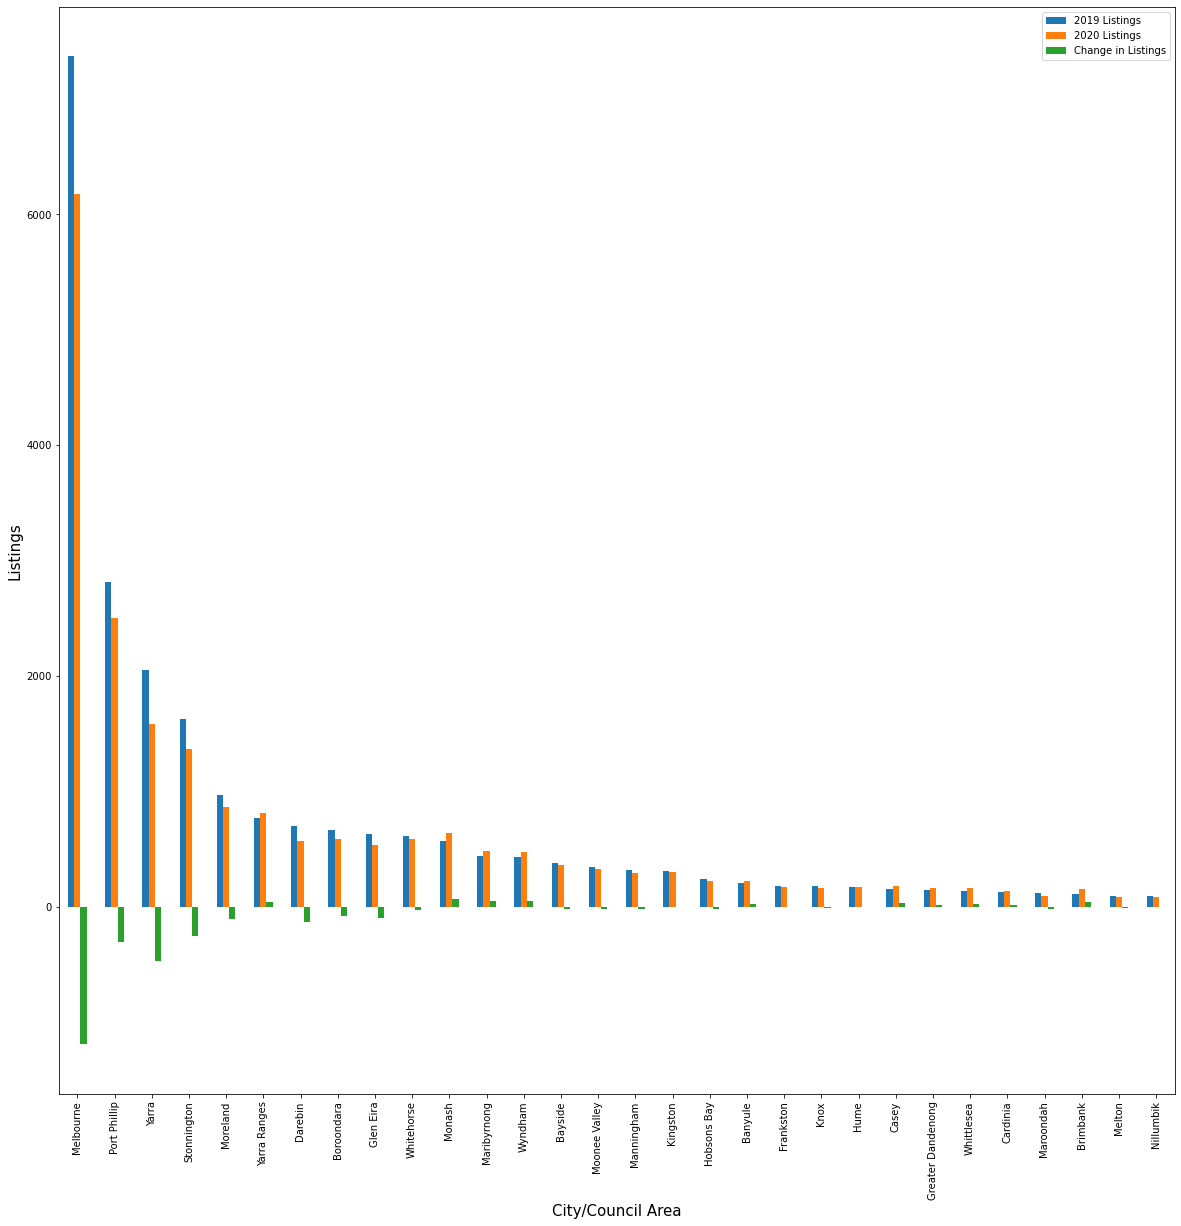

In [174]:
#neighborhood_count.plot(kind = 'bar', color = 'b', align = 'center', figsize = (20,20))
neighborhood_count20.plot(kind = 'bar', y = ['2019 Listings', '2020 Listings', 'Change in Listings'], align = 'center', figsize = (20,20))
plt.xlabel('City/Council Area', fontsize = 15)
plt.ylabel('Listings', fontsize = 15)

In [234]:
list_2019 = sum_list_2019
list_2019['Booked_2019'] = 365 - list_2019['availability_365']
neighborhood_book2019 = list_2019.groupby('city').mean()
total_days = pd.DataFrame(neighborhood_book2019['Booked_2019'])
neighborhood_book2019 = list_2019.groupby('city').median()
total_days['Median Booked 2019'] = neighborhood_book2019['Booked_2019']


list_2020 = list_2020
list_2020['Booked_2020'] = 365 - list_2020['availability_365']
neighborhood_book20 = list_2020.groupby('neighbourhood_cleansed').mean()
total_days20 = pd.DataFrame(neighborhood_book20['Booked_2020'])
neighborhood_book20 = list_2020.groupby('neighbourhood_cleansed').median()
total_days20['Median Booked 2020'] = neighborhood_book20['Booked_2020']
total_days = pd.merge(total_days, total_days20, left_index = True, right_index = True, how = 'outer')
total_days = total_days.sort_values(by = 'Booked_2019', ascending = False)
total_days.head()

,Booked_2019,Median Booked 2019,Booked_2020,Median Booked 2020
city,,,,
Moreland,265.514995,320.0,252.209733,287.0
Yarra,265.232796,327.0,253.365019,341.0
Darebin,259.992837,323.0,256.111111,333.0
Melbourne,242.376629,289.0,231.425656,275.0
Stonnington,239.495373,294.0,235.598977,278.0


In [175]:
file_to_load = "../airbnb/AirBnB 2020/calendar_2020.csv"
cal_2020 = pd.read_csv(file_to_load)

cal_2020['date'] = pd.to_datetime(cal_2020['date'])
cal_2020['day'] = cal_2020['date'].dt.day
cal_2020['month'] = cal_2020['date'].dt.month
cal_2020['year'] = cal_2020['date'].dt.year

month_2020 = cal_2020.groupby(['year','month']).count()

In [176]:
file_to_load = "../airbnb/AirBnB 2021/calendar_2021.csv"
cal_2021 = pd.read_csv(file_to_load)

cal_2021['date'] = pd.to_datetime(cal_2021['date'])
cal_2021['day'] = cal_2021['date'].dt.day
cal_2021['month'] = cal_2021['date'].dt.month
cal_2021['year'] = cal_2021['date'].dt.year

month_2021 = cal_2021.groupby(['year','month']).count()

In [35]:
days_cost = pd.merge(cal_2019, list_2019_price, on = 'listing_id', how = 'left')
daily_price_2019 = days_cost.groupby('listing_id').mean()
daily_price_2019.describe()

,day,month,year,price_y
count,22895.000000,2.289500e+04,22895.000000,22895.000000
mean,15.720548,6.526027e+00,2018.931509,148.004368
std,0.000000,8.881978e-16,0.000070,210.883253
min,15.720548,6.526027e+00,2018.931507,0.000000
25%,15.720548,6.526027e+00,2018.931507,71.000000
50%,15.720548,6.526027e+00,2018.931507,111.000000
75%,15.720548,6.526027e+00,2018.931507,165.000000
max,15.720548,6.526027e+00,2018.934247,12624.000000


In [29]:
#Finding all available booking ID's and total days available
avail_2019 = cal_2019.loc[cal_2018['available'] == 't']
avail_2019 = avail_2019.groupby('listing_id').count()
avail_2019 = pd.merge(avail_2019, list_2019_price, on = 'listing_id', how = 'left')
avail_2019 = avail_2019.rename(columns = {'available':'Number of Days Available',
                                          'price_y': 'Price per Night'})
avail_2019 = avail_2019[['listing_id','Number of Days Available','Price per Night']]
avail_2019

,listing_id,Number of Days Available,Price per Night
0,9835,365,60
1,10803,213,35
2,12936,326,159
3,16760,328,69
4,38271,328,98
...,...,...,...
17392,30592332,82,55
17393,30592345,365,129
17394,30592362,15,53
17395,30592590,349,130


In [30]:
#Finding all booked listing_id's and number of days booked
booked_2019 = cal_2019.loc[cal_2019['available'] == 'f']
booked_2019 = booked_2019.groupby('listing_id').count()
booked_2019 = pd.merge(booked_2019, list_2019_price, on = 'listing_id', how = 'left')
booked_2019 = booked_2019.rename(columns = {'available':'Number of Days Booked',
                                          'price_y': 'Price per Night'})
booked_2019 = booked_2019[['listing_id','Number of Days Booked','Price per Night']]
booked_2019

,listing_id,Number of Days Booked,Price per Night
0,10803,152,35
1,12936,39,159
2,15246,365,50
3,16760,37,69
4,38271,37,98
...,...,...,...
22326,30592128,336,30
22327,30592332,283,55
22328,30592362,350,53
22329,30592590,16,130


In [31]:
cal_group = days_cost.groupby(['listing_id','available']).count()

cal_group

date  price_x  price_y
listing_id available                        
9835       t           365      365      365
10803      f           152        0      152
           t           213      213      213
12936      f            39        0       39
           t           326      326      326
...                    ...      ...      ...
30592362   t            15       15       15
30592590   f            16        0       16
           t           349      349      349
30593623   f           297        0      297
           t            68       68       68

[39728 rows x 3 columns]

In [32]:
cal_2019['date'] = pd.to_datetime(cal_2019['date'])
cal_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8356675 entries, 0 to 8356674
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   listing_id  int64         
 1   date        datetime64[ns]
 2   available   object        
 3   price       object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 255.0+ MB


In [33]:
cal_2019['day'] = cal_2019['date'].dt.day
cal_2019['month'] = cal_2019['date'].dt.month
cal_2019['year'] = cal_2019['date'].dt.year

In [34]:
month_2019 = cal_2019.groupby(['year','month']).count()
month_2019

listing_id    date  available   price     day
year month                                               
2018 12         572360  572360     572360  186899  572360
2019 1          709745  709745     709745  312593  709745
     2          641060  641060     641060  323736  641060
     3          709745  709745     709745  307871  709745
     4          686850  686850     686850  295074  686850
     5          709745  709745     709745  315288  709745
     6          686850  686850     686850  231450  686850
     7          709745  709745     709745  226422  709745
     8          709745  709745     709745  227130  709745
     9          686850  686850     686850  207415  686850
     10         709745  709745     709745  213627  709745
     11         686850  686850     686850  205241  686850
     12         137385  137385     137385   41446  137385